In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import utils.params as pars
import utils.policies as polc
import utils.experiment as expt
import utils.network as qnet
import utils.plotter as pltutils

reload(pars)
reload(polc)
reload(expt)
reload(qnet)
reload(pltutils);

## Simulation Parameters

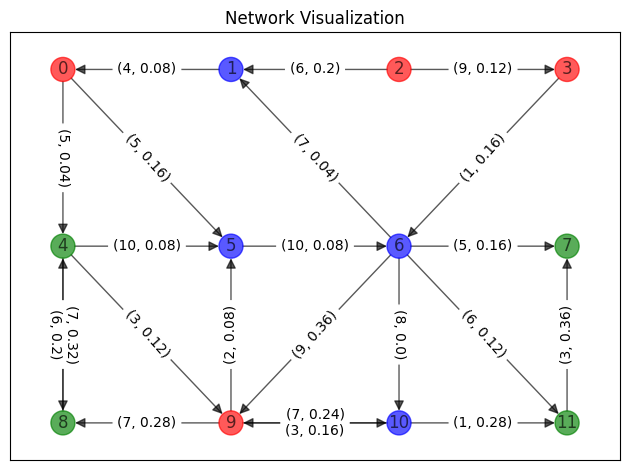

Arrival rates = [2.5, 2.0, 0.5, 2.5]
Source nodes = [0, 2, 3, 9]
Destination nodes = [11, 8, 4, 7]
Noise variance = 0.1


In [2]:
# get default simulation parameters
network_type = 'multi-user' # available choices = 'single-user' 'multi-user'
simulation_params = pars.get_simulation_params(network_type, is_regret_sim = False)

# redefine some variables locally for ease of use
T_horizon      = simulation_params.T_horizon
arrival_rate_scaling = simulation_params.arrival_rate_scaling
noise_variance = simulation_params.noise_variance

print('Arrival rates = ' + str(simulation_params.arrival_rate_list))
print('Source nodes = ' + str(simulation_params.source_list))
print('Destination nodes = ' + str(simulation_params.destination_list))
print('Noise variance = ' + str(simulation_params.noise_variance))

## Static Policy

In [3]:
# get static minimum rates (Theorem 1 of the paper)
stat_edge_rates, backlog_cost_C_L = polc.get_static_policy(simulation_params)

# get minimum static costs and convert them to per-time arrays
N_edges         = len(simulation_params.edge_capacities)
N_commodities   = len(simulation_params.destination_list)
stat_edge_rates = np.sum(stat_edge_rates.reshape([N_commodities, N_edges]), axis=0)
stat_cost_at_tt = (stat_edge_rates@simulation_params.true_edge_costs)*np.ones([T_horizon,])
stat_cost_till_tt = stat_cost_at_tt*np.arange(0,T_horizon)

## DPOP Policy (Known T, no doubling trick)

In [4]:
# change parameters for this value of T
simulation_params = pars.set_simulation_params(simulation_params, T_horizon)

# run experiment for this value of T
knownT_network = expt.run_experiment(simulation_params, custom_seed = 13, store_extra_info = True)

# save cost and backlog values
knownT_tran_cost_at_tt, knownT_tran_cost_till_tt, \
    knownT_backlog_at_tt, knownT_backlog_cost_at_tt = expt.calculate_per_time_metrics(knownT_network, backlog_cost_C_L)
knownT_regret = knownT_tran_cost_till_tt + knownT_backlog_cost_at_tt - stat_cost_till_tt

/Users/sathwikchadaga/MIT Dropbox/Sathwik Chadaga/MIT/Research/Learning DPOP/Simulations/Optimistic-DPP-Improved-Regret/utils/network.py:121: RuntimeWarning: divide by zero encountered in matmul
  self.planned_tran_cost_at_tt[self.tt] = np.mean(np.sum(planned_edge_rates, axis=1)@self.true_edge_costs, axis=0)
/Users/sathwikchadaga/MIT Dropbox/Sathwik Chadaga/MIT/Research/Learning DPOP/Simulations/Optimistic-DPP-Improved-Regret/utils/network.py:121: RuntimeWarning: overflow encountered in matmul
  self.planned_tran_cost_at_tt[self.tt] = np.mean(np.sum(planned_edge_rates, axis=1)@self.true_edge_costs, axis=0)
/Users/sathwikchadaga/MIT Dropbox/Sathwik Chadaga/MIT/Research/Learning DPOP/Simulations/Optimistic-DPP-Improved-Regret/utils/network.py:121: RuntimeWarning: invalid value encountered in matmul
  self.planned_tran_cost_at_tt[self.tt] = np.mean(np.sum(planned_edge_rates, axis=1)@self.true_edge_costs, axis=0)
/Users/sathwikchadaga/MIT Dropbox/Sathwik Chadaga/MIT/Research/Learning DPOP/

## DPOP Policy (Unknown T, using doubling trick)

In [5]:
# intialization
T_horizon_next = 2
doubling_factor = 2
unknownT_network = qnet.OnlineQueueNetwork(simulation_params, custom_seed = 13)
while(T_horizon_next < T_horizon):
    # T doubling step
    T_horizon_next = min( max(int(doubling_factor*T_horizon_next), T_horizon_next+1), T_horizon )

    # change parameters for this value of T
    simulation_params = pars.set_simulation_params(simulation_params, T_horizon_next)
    unknownT_network.T_horizon = T_horizon_next

    # run experiment until time steps proceeds up to this value of T
    unknownT_network = expt.run_experiment(simulation_params, queueing_network = unknownT_network)
    
# save cost and backlog values
unknownT_tran_cost_at_tt, unknownT_tran_cost_till_tt, \
    unknownT_backlog_at_tt, unknownT_backlog_cost_at_tt = expt.calculate_per_time_metrics(unknownT_network, backlog_cost_C_L)
unknownT_regret = unknownT_tran_cost_till_tt + unknownT_backlog_cost_at_tt - stat_cost_till_tt

## Oracle Policy

In [6]:
# change parameters for this value of T and set noise to 0 (oracle)
simulation_params.noise_variance = 0
simulation_params.beta = 0
simulation_params = pars.set_simulation_params(simulation_params, T_horizon)

# run experiment for this value of T
oracle_network = expt.run_experiment(simulation_params, custom_seed = 13, store_extra_info = True)

# save cost and backlog values
oracle_tran_cost_at_tt, oracle_tran_cost_till_tt, \
    oracle_backlog_at_tt, oracle_backlog_cost_at_tt = expt.calculate_per_time_metrics(oracle_network, backlog_cost_C_L)
oracle_regret = oracle_tran_cost_till_tt + oracle_backlog_cost_at_tt - stat_cost_till_tt

## Save Results

In [ ]:
save_folder = './results/' + network_type + '/' # set to None if dont want to save
save_folder = None

save_result = np.vstack((stat_cost_till_tt, 
                         unknownT_tran_cost_at_tt, unknownT_backlog_at_tt,
                         unknownT_tran_cost_till_tt, unknownT_backlog_cost_at_tt,
                         knownT_tran_cost_at_tt, knownT_backlog_at_tt,
                         knownT_tran_cost_till_tt, knownT_backlog_cost_at_tt,
                         oracle_tran_cost_at_tt, oracle_backlog_at_tt,
                         oracle_tran_cost_till_tt, oracle_backlog_cost_at_tt))
save_file = 'run-lambda-' + ('%.3f'%(arrival_rate_scaling)).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
if(save_folder is not None): np.save(save_folder + save_file, save_result)

In [20]:
save_result = knownT_network.cost_mape
save_file = 'cost-errors-lambda-' + ('%.3f'%(arrival_rate_scaling)).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
if(save_folder is not None): np.save(save_folder + save_file, save_result)

In [21]:
save_result = np.vstack((knownT_network.all_edge_rates, oracle_network.all_edge_rates))
save_file = '' \
'edge-rates-lambda-' + ('%.3f'%(arrival_rate_scaling)).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
if(save_folder is not None): np.save(save_folder + save_file, save_result)

## Results Comparison

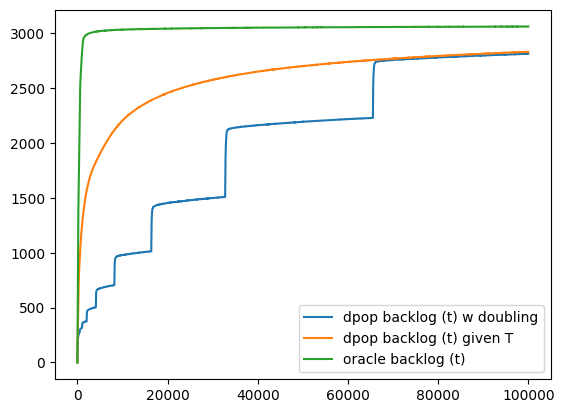

In [10]:
plt.plot(unknownT_backlog_at_tt, label = 'dpop backlog (t) w doubling')
plt.plot(knownT_backlog_at_tt, label = 'dpop backlog (t) given T')
plt.plot(oracle_backlog_at_tt, label = 'oracle backlog (t)')
plt.legend()
plt.show()

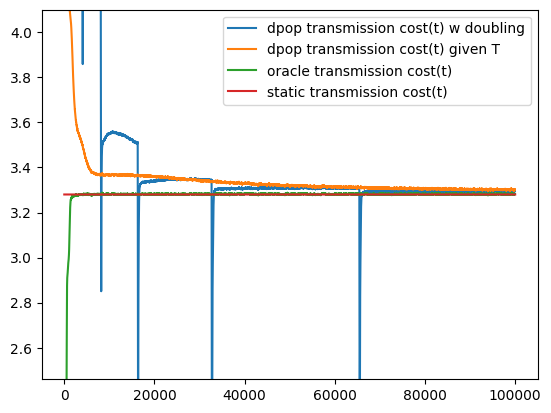

In [11]:
def windowed_average(input_array, window_size = 100):
    output_array = np.convolve(input_array, np.ones(window_size)/window_size, mode='valid')
    return np.append(input_array[0], output_array) # append used to match input and output size

plt.plot(windowed_average(unknownT_tran_cost_at_tt), label = 'dpop transmission cost(t) w doubling')
plt.plot(windowed_average(knownT_tran_cost_at_tt), label = 'dpop transmission cost(t) given T')
plt.plot(windowed_average(oracle_tran_cost_at_tt), label = 'oracle transmission cost(t)')
plt.plot(stat_cost_at_tt, label = 'static transmission cost(t)')
plt.ylim([0.75*stat_cost_at_tt[0],1.25*stat_cost_at_tt[0]])
plt.legend()
plt.show()

In [12]:
# plt.plot(unknownT_tran_cost_till_tt, label = 'dpop cumsum tran cost(t) w doubling')
# plt.plot(knownT_tran_cost_till_tt, label = 'dpop cumsum tran cost(t) given T')
# plt.plot(oracle_tran_cost_till_tt, label = 'oracle cumsum tran cost(t)')
# # plt.plot(stat_cost_till_tt, label = 'stat cost*t')
# plt.legend()
# plt.show()

In [13]:
# plt.plot(unknownT_tran_cost_till_tt + unknownT_backlog_cost_at_tt, label = 'dpop cost(t) w doubling')
# plt.plot(knownT_tran_cost_till_tt + knownT_backlog_cost_at_tt, label = 'dpop cost(t) given T')
# plt.plot(oracle_tran_cost_till_tt + oracle_backlog_cost_at_tt, label = 'oracle cost(t)')
# plt.plot(stat_cost_till_tt, label = 'stat cost*t')
# plt.legend()
# plt.show()

In [14]:
# plt.plot(unknownT_regret, label = 'dpop regret(t) w doubling')
# plt.plot(knownT_regret, label = 'dpop regret(t) given T')
# plt.plot(oracle_regret, label = 'oracle regret(t)')
# plt.legend()
# plt.show()

In [15]:
def get_average_rates(queueing_network, until_T = -1):
    return np.mean(queueing_network.all_edge_rates[:until_T,:], axis = 0)/queueing_network.edge_capacities

In [16]:
sorted_indices = np.argsort(np.mean(oracle_network.all_edge_rates, axis = 0))[-1::-1]

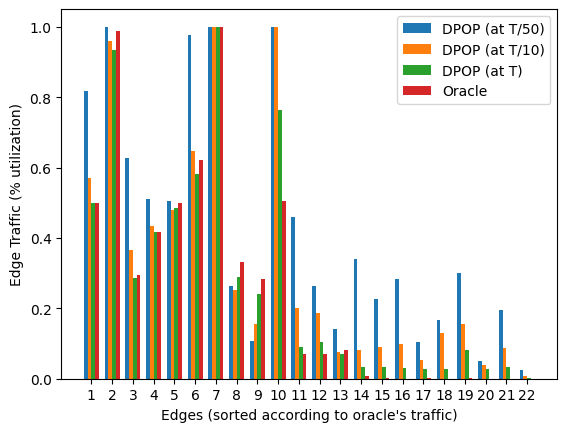

In [17]:
mult = 4
width = 2
offset = 3
x = (mult*width + offset)*np.arange(stat_edge_rates.shape[0])

plt.bar(x, get_average_rates(knownT_network, until_T = int(T_horizon/50))[sorted_indices], width, label='DPOP (at T/50)')
plt.bar(x+width, get_average_rates(knownT_network, until_T = int(T_horizon/10))[sorted_indices], width, label='DPOP (at T/10)')
plt.bar(x+2*width, get_average_rates(knownT_network, until_T = T_horizon)[sorted_indices], width, label='DPOP (at T)')
plt.bar(x+3*width, get_average_rates(oracle_network)[sorted_indices], width, label='Oracle')
# plt.bar(x+4*width, stat_edge_rates[sorted_indices], width, label='Stat')

plt.legend()
plt.xticks(x+1.5*width, np.arange(stat_edge_rates.shape[0])+1)
plt.xlabel('Edges (sorted according to oracle\'s traffic)')
plt.ylabel('Edge Traffic (% utilization)')
plt.show()

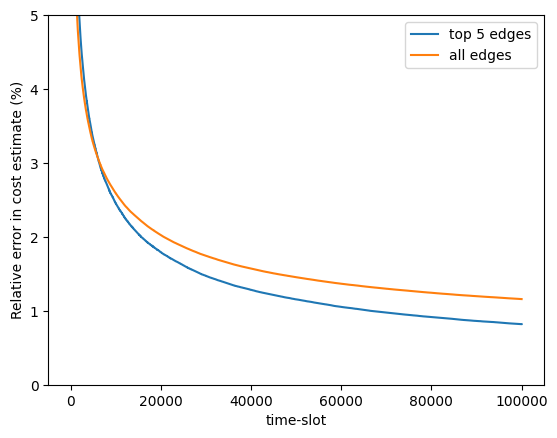

In [18]:
K = 5
plt.plot(np.mean(knownT_network.cost_mape[:,sorted_indices[:K]], axis=1)*100, label = 'top 5 edges')
plt.plot(np.mean(knownT_network.cost_mape, axis=1)*100, label = 'all edges')

plt.ylabel('Relative error in cost estimate (%)')
plt.xlabel('time-slot')
plt.ylim([0,5])
plt.legend()
plt.show()